In [1]:
from matplotlib import pyplot as plt
import numpy as np
from agreement import logZ
from utils.config import load
import glob
import os
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from matplotlib import cm

In [2]:
def agreement(mu12, k):
    log_fvm = (np.log(4 * np.pi) - 2 * logZ(k) + logZ(mu12 * k) ) / np.log(2)
    return log_fvm

def agreement_T(mu12, T):
    log_fvm = (np.log(4 * np.pi) - 2 * logZ(1/T) + logZ(mu12 / T) ) / np.log(2)
    return log_fvm

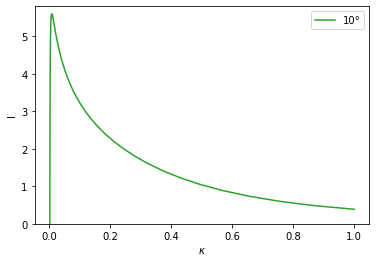

In [92]:
T=np.geomspace(0.001, 1)
plt.plot(T, agreement_T(np.sqrt(2+2*np.cos(10/180*np.pi)), T), label="10°", color="tab:green")
plt.ylim(0, 5.8)
plt.legend()
plt.xlabel(r"$\kappa$")
plt.ylabel("I");

In [3]:
def opt_agreement(mu12):
    k = np.linspace(0,1000, 50000)
    a = agreement(mu12, k)
    idx = np.nanargmax(a)
    return k[idx], a[idx]

In [222]:
theta = np.linspace(0.01, 90, 200)
mu12 = [np.sqrt(2+2*np.cos(t/180*np.pi)) for t in theta]
k_opt = []
a_opt = []
for m in mu12:
    k, a = opt_agreement(m)
    k_opt.append(k)
    a_opt.append(a)

/local/home/vwegmayr/ijcv19/agreement.py:275: RuntimeWarning: divide by zero encountered in log1p
  return np.log(2*np.pi) + kappa + np.log1p(- expk2) - np.log(kappa)
/local/home/vwegmayr/ijcv19/agreement.py:275: RuntimeWarning: divide by zero encountered in log
  return np.log(2*np.pi) + kappa + np.log1p(- expk2) - np.log(kappa)
/local/home/vwegmayr/ijcv19/agreement.py:275: RuntimeWarning: invalid value encountered in subtract
  return np.log(2*np.pi) + kappa + np.log1p(- expk2) - np.log(kappa)


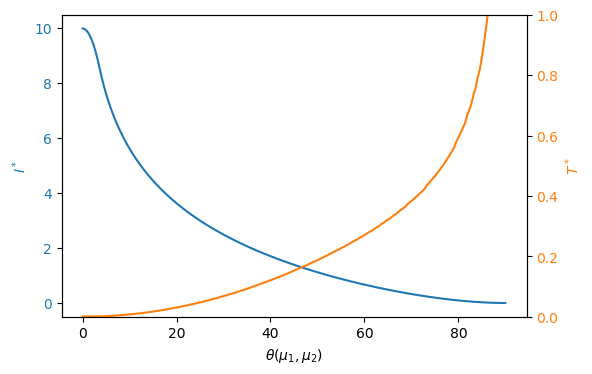

In [54]:
fig, ax1 =plt.subplots(dpi=100)
ax1.plot(theta, a_opt, color="tab:blue")
ax1.set_ylabel(r"$I^*$", color="tab:blue")
ax1.set_xlabel(r"$\theta(\mu_1,\mu_2)$")
ax1.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(theta, 1/np.array(k_opt), color="tab:orange")
ax2.set_ylabel(r"$T^*$", color="tab:orange");
ax2.tick_params(axis='y', labelcolor="tab:orange")
ax2.set_ylim(0,1);

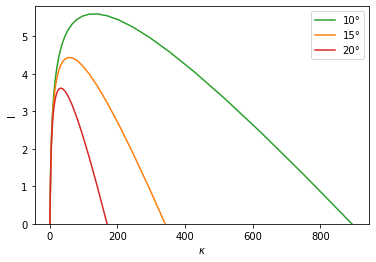

In [58]:
k=np.geomspace(0.1, 900)
plt.plot(k, agreement(np.sqrt(2+2*np.cos(10/180*np.pi)), k), label="10°", color="tab:green")
plt.plot(k, agreement(np.sqrt(2+2*np.cos(15/180*np.pi)), k), label="15°", color="tab:orange")
plt.plot(k, agreement(np.sqrt(2+2*np.cos(20/180*np.pi)), k), label="20°", color="tab:red")
plt.ylim(0, 5.8)
plt.legend()
plt.xlabel(r"$\kappa$")
plt.ylabel("I");

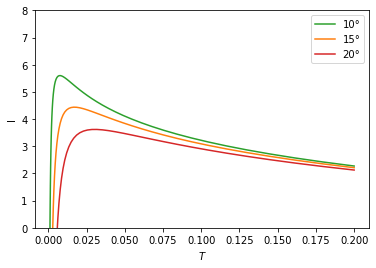

In [86]:
k=np.geomspace(5, 1000)
plt.plot(1/k, agreement(np.sqrt(2+2*np.cos(10/180*np.pi)), k), label="10°", color="tab:green")
plt.plot(1/k, agreement(np.sqrt(2+2*np.cos(15/180*np.pi)), k), label="15°", color="tab:orange")
plt.plot(1/k, agreement(np.sqrt(2+2*np.cos(20/180*np.pi)), k), label="20°", color="tab:red")
plt.ylim(0,8)
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel("I");

In [4]:
def effective_T(angle):
    lut = np.load("effective_angle_lookup_98.npz")
    _, ok = np.unique(lut["angle"], return_index=True)
    
    spl = splrep(lut["angle"][ok], lut["T"][ok], s=0)
    return splev(angle, spl, der=0)

def effective_angle(T):
    lut = np.load("effective_angle_lookup_98.npz")
    f = interp1d(lut["T"], lut["angle"], kind='cubic')
    return f(T)

def bits_from(T):
    theta = effective_angle(T)
    solid_angle = 2 * np.pi * (1 - np.cos(theta))
    n_cones = 4 * np.pi / solid_angle
    
    return np.log2(n_cones)

def get_max(x, y):
    spl = splrep(x, y, s=0)
    xx = np.geomspace(x.min(), x.max(),1000)
    values = splev(xx, spl, der=0)
    idx = np.argmax(values)
    return xx[idx], values[idx]

def get_max_from(agreement_dir, key="value"):
    results = get_results(os.path.join(agreement_dir, "agreement_T=*.yml"))
    return get_max(results["temperature"], results[key])

In [5]:
def get_results(yml_path_glob):
    results={}
    for config_path in glob.glob(yml_path_glob):
        config = load(config_path)
        for k, v in config.items():
            if k in results:
                results[k].append(v)
            else:
                results[k] = [v]
 
    order = np.argsort(results["temperature"])
    
    for k,v in results.items():
        if len(results[k]) == len(order):
            results[k] = np.array(results[k])[order]
        else:
            results[k] = []
        
    return results

In [6]:
def plot_recognized(agreement_dir):
    results = get_results(os.path.join(agreement_dir, "agreement_T=*.yml"))
    
    plt.figure(dpi=100)
    plt.plot(results["temperature"]/ effective_T(np.pi/180*15), results["n_bundles"], "-o", color="tab:blue",
             label="1st instance")
    
    plt.ylabel("Bundles")
    plt.xlabel(r"$T/T_{15°}$")

    plt.plot(results["temperature"]/ effective_T(np.pi/180*15), results["n_recognized"], "-o",
             color="tab:orange", label="Recognized")
    
    plt.plot(results["temperature"]/ effective_T(np.pi/180*15), results["n_recognized"]-results["no_overlap"], "-o",
             color="tab:green", label="With Overlap")
    
    plt.legend()

In [7]:
def plot(agreement_dir, key):
    results = get_results(os.path.join(agreement_dir, "agreement_T=*.yml"))
    #plt.figure(dpi=100)
    plt.plot(results["temperature"]/ effective_T(np.pi/180*15), results[key], "-o", color="tab:blue")
    plt.ylabel(key)
    plt.xlabel(r"$T/T_{15°}$")

In [8]:
def plot_parts(agreement_dir):
    results = get_results(os.path.join(agreement_dir, "agreement_T=*.yml"))
    
    fig, ax1 =plt.subplots(dpi=100)
    ax1.plot(results["temperature"]/ effective_T(np.pi/180*15), results["mean"], "-o", color="tab:blue")
    ax1.set_ylabel("Per Fixel Posterior Agreement")
    ax1.set_xlabel(r"$T/T_{15°}$")
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    
    it, imax = get_max_from(agreement_dir, key="mean")

    ax1.plot([it/ effective_T(np.pi/180*15)],[imax], "o", color="tab:red", markersize=10)
    
    ax2 = ax1.twinx()
    if "n_fixels" in results:
        y = results["n_fixels"]/results["n_fixels_gt"]
        which="fixels"
    elif "n_fixels_sum" in results:
        y = results["n_fixels_sum"]/results["n_fixels_gt"]
        which="fixels"
    else:
        y = results["n_vox"]/results["n_wm"]
        which="voxels"
        
    ax2.plot(results["temperature"]/ effective_T(np.pi/180*15), y, "-o",
             color="tab:orange")
    ax2.set_ylabel("Matching {}".format(which) + r" ($N_f^{-1}$)", color="tab:orange");
    ax2.tick_params(axis='y', labelcolor="tab:orange")

In [9]:
def get_missing_T(agreement_dir):
    results = get_results(os.path.join(agreement_dir, "agreement_T=*.yml"))
    t = [m.split("_T=")[1].split(".h")[0] for m in results["model_path"]]
    
    model_dir = os.path.dirname(agreement_dir)
    models = glob.glob(os.path.join(model_dir, "model_T=*.h5"))
    T = [m.split("_T=")[1].split(".h")[0] for m in models]
    print(list(set(T) - set(t)))

In [10]:
get_missing_T("../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_7")

['0.0045', '0.1000']


In [10]:
def plot_value(*agreement_dirs):
    results = {adir:get_results(os.path.join(adir, "agreement_T=*.yml")) for adir in agreement_dirs}
    plt.figure(dpi=100)
    for k,v in results.items():
        if "temperature" in v and "value" in v:
            plt.plot(v["temperature"] / effective_T(np.pi/180*15)
                     , v["value"], "-o", label=k.split("/")[-1],
                    alpha=0.5)
            Tmax, Vmax = get_max(v["temperature"] / effective_T(np.pi/180*15)
                                 , v["value"])

            plt.plot([Tmax, Tmax], [min(v["value"]), Vmax], "--", linewidth=1, color="tab:blue")
            
            print(Tmax, Vmax)
    
    plt.xlabel(r"$T/T_{15°}$")
    plt.ylabel("Tractogram Posterior Agreement")
    #plt.xlim(0.002,0.1)
    #plt.legend();

4.548311221934442 3.406456950342696
7.962438308369642 2.5363120072632506


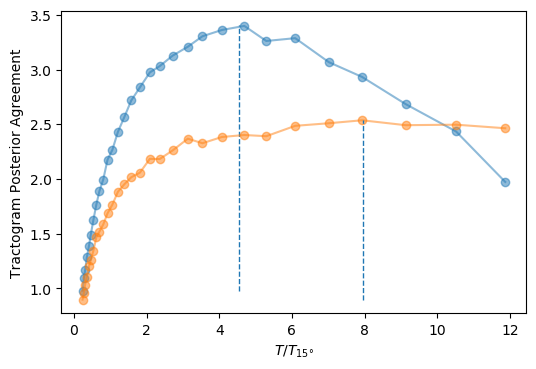

In [23]:
plot_value(
    #"../models/Entrack/conditional/2019-11-13/22:24:08/agreement_sampled_final_13",
    #"../models/Entrack/conditional/2019-11-13/22:24:08/agreement_sampled_jb_1",
    #"../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_1",
    #"../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_2",
    "../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_6",
    "../models/Entrack/conditional/2019-11-24/01:18:33/agreement_mean_jb_1",
    #"../models/Entrack/conditional/2019-11-13/22:24:08/agreement_mean_jb_1",
    #"../models/Entrack/conditional/2019-11-13/22:24:08/agreement_sampled_jb_2",
)

Text(0, 0.5, 'Mean Fixel Agreement')

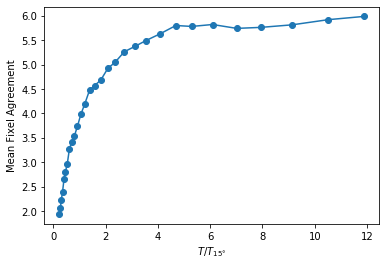

In [21]:
plot(
    "../models/Entrack/conditional/2019-11-24/01:18:33/agreement_mean_jb_1",
    "mean"
)
plt.ylabel("Mean Fixel Agreement")

Text(0, 0.5, 'Mean Fixel Agreement')

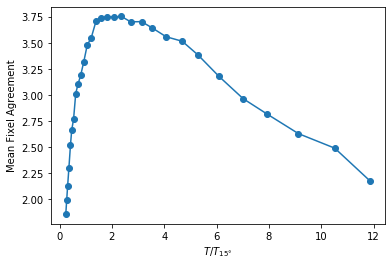

In [108]:
plot(
    "../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_6",
    "mean"
)
plt.ylabel("Mean Fixel Agreement")

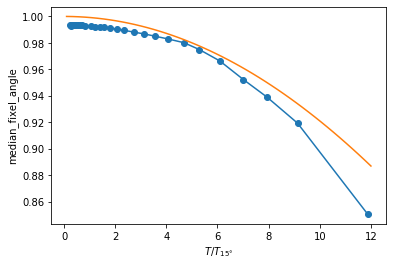

In [221]:
plot(
    "../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_5",
    "median_fixel_angle"
)
T=np.linspace(0.1,12)
plt.plot(T, np.cos(0.04*T), color="tab:orange")

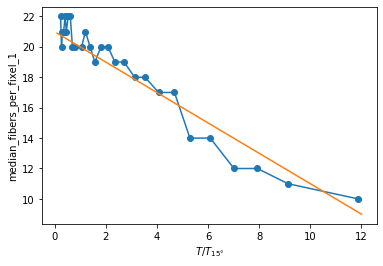

In [228]:
plot(
    "../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_5",
    "median_fibers_per_fixel_1"
)
def W(T):
    return 1 / np.tanh(1/T) - T
T=np.linspace(0.1,12)
plt.plot(T, 21-T, color="tab:orange")

In [209]:
np.mean(15+5*np.tanh(0.4*(5.5-T)))

14.554256784745249

In [230]:
1/((1/4.2)**2 / 2)

35.28

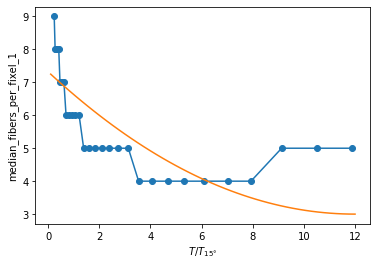

In [156]:
plot(
    "../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_6",
    "median_fibers_per_fixel_1"
)
T=np.linspace(0.1,12)
plt.plot(T, 3 + 0.03*(T-12)**2, color="tab:orange")

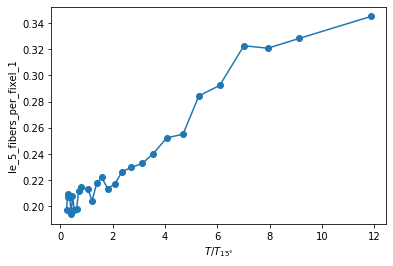

In [111]:
plot(
    "../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_5",
    "le_5_fibers_per_fixel_1"
)

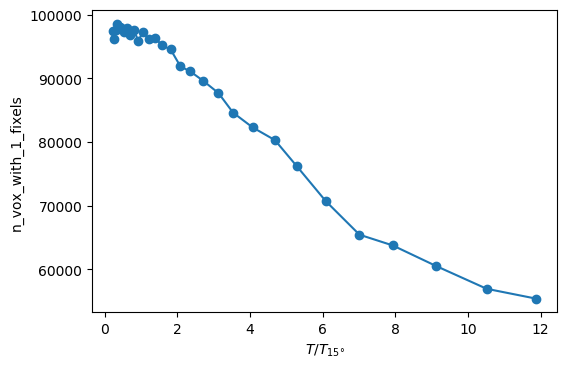

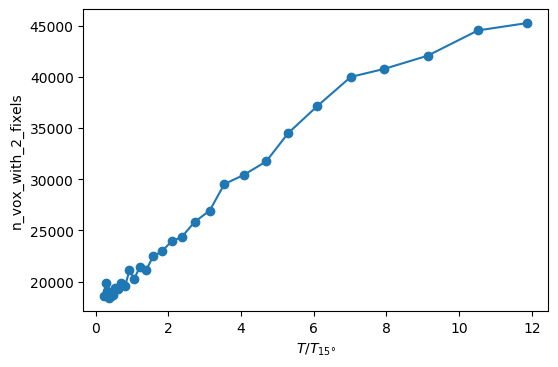

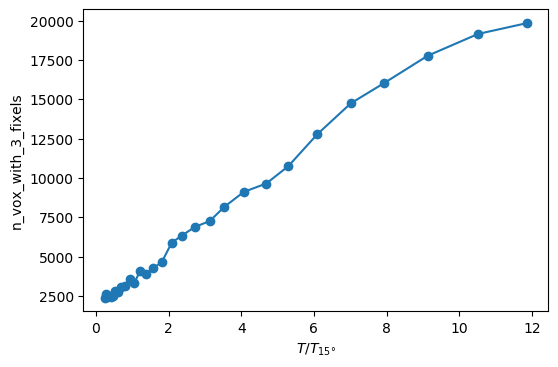

In [17]:
plot("../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_2", "n_vox_with_1_fixels")
plot("../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_2", "n_vox_with_2_fixels")
plot("../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_2", "n_vox_with_3_fixels")

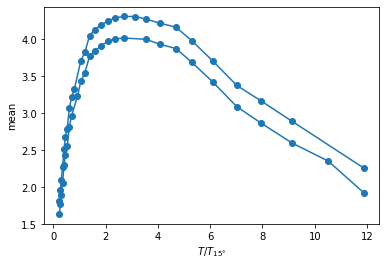

In [97]:
plot("../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_3", "mean")
plot("../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_5", "mean")

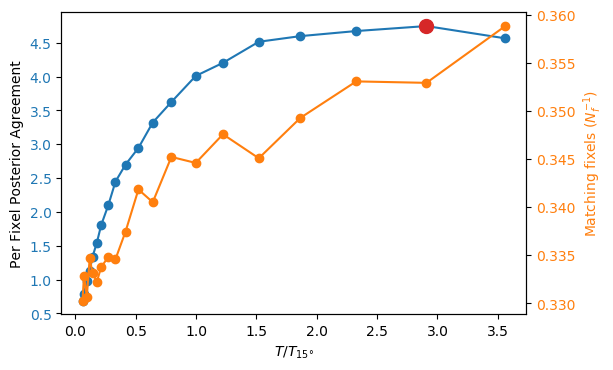

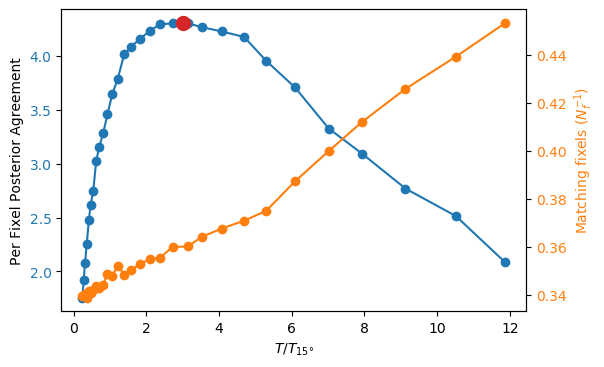

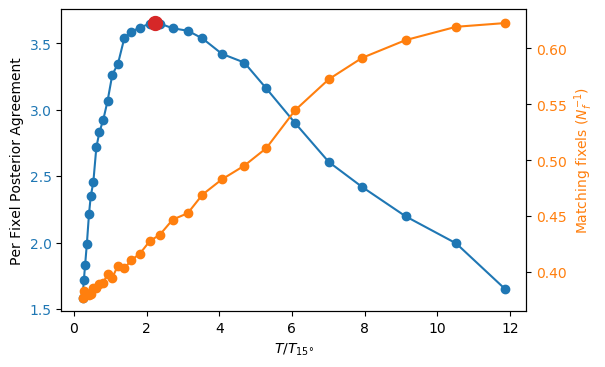

In [11]:
plot_parts("../models/Entrack/conditional/2019-11-13/22:24:08/agreement_sampled_jb_1")
plot_parts("../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_1")
plot_parts("../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_2")

# ===========================================================

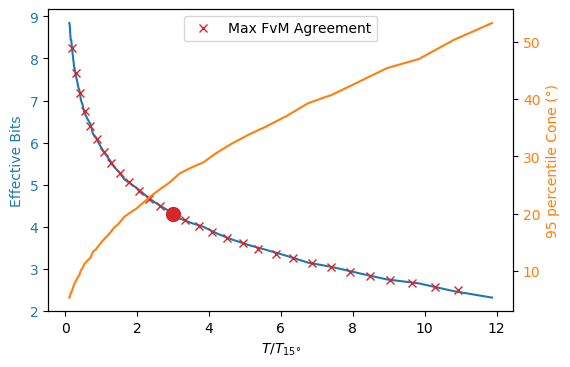

In [59]:
T=np.geomspace(0.001, 0.1)

fig, ax1 =plt.subplots(dpi=100)
ax1.plot(T/ effective_T(np.pi/180*15), bits_from(T), color="tab:blue")
ax1.set_ylabel("Effective Bits", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_xlabel(r"$T/T_{15°}$")
#ax1.set_xscale("log")
ax1.tick_params(axis='y', labelcolor="tab:blue")

theta=np.linspace(4,30, 30)
Tmax=[]
Vmax=[]
n=1.35
for th in theta:
    t=np.geomspace(0.001, 0.1)
    tmax, vmax = get_max(
        t/ effective_T(np.pi/180*15),
        agreement(np.sqrt(2+2*np.cos(th/180*np.pi)), n/t)
    )
    Tmax.append(tmax)
    Vmax.append(vmax)
ax1.plot(Tmax, Vmax, "x", color="tab:red", label="Max FvM Agreement")
ax1.legend(loc='upper center')

#it, imax = get_max_from("../models/Entrack/conditional/2019-11-13/22:24:08/agreement_sampled_jb_1", key="mean")
it, imax = get_max_from("../models/Entrack/conditional/2019-11-24/01:18:33/agreement_sampled_jb_1", key="mean")

ax1.plot([it/ effective_T(np.pi/180*15)],[imax], "o", color="tab:red", markersize=10)

ax2 = ax1.twinx()
ax2.plot(T/ effective_T(np.pi/180*15), effective_angle(T)/np.pi*180, color="tab:orange")
#ax2.plot([1,1,5],[4,15,15], "--", color="tab:orange", linewidth=1)
ax2.set_ylabel("95 percentile Cone (°)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange");

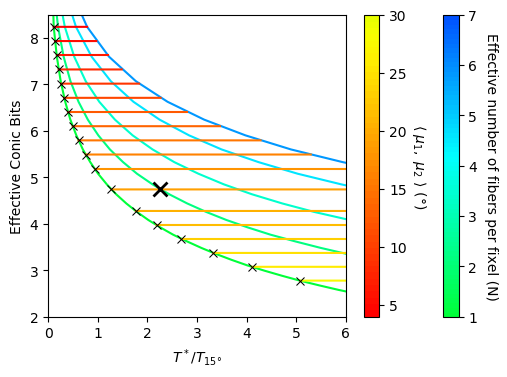

In [358]:
g2bcolors = cm.get_cmap('hsv', 256)(np.linspace(0.5 - 1/8, 0.5 + 1/8, 256))
g2bcmp = ListedColormap(g2bcolors)

r2ycolors = cm.get_cmap('hsv', 256)(np.linspace(0, 1.5/8, 256))
r2ycmp = ListedColormap(r2ycolors)


T=np.geomspace(0.001, 0.1)

fig, ax1 =plt.subplots(dpi=100)
#ax1.plot(T/ effective_T(np.pi/180*15), bits_from(T), color="tab:red")
ax1.set_ylabel("Effective Conic Bits", color="k")
ax1.tick_params(axis='y', labelcolor="k")
ax1.set_xlabel(r"$T^*/T_{15°}$")
#ax1.set_xscale("log")
ax1.tick_params(axis='y', labelcolor="k")

N=np.array([1,1.78,3,5,7,])

for ni, n in enumerate(N):
    Tmax=[]
    Vmax=[]
    tmax=0
    theta=[3]
    while tmax < 8:
        tmax, vmax = get_max(
            T/ effective_T(np.pi/180*15),
            agreement(np.sqrt(2+2*np.cos(theta[-1]/180*np.pi)), n/T)
        )
        Tmax.append(tmax)
        Vmax.append(vmax)
        theta.append(theta[-1]+1)
        
    theta.pop(-1)
    
    ax1.plot(Tmax, Vmax, color=g2bcmp(ni/len(N)))
      
TH = [ 4.        ,  4.44749888,  4.94506157,  5.49828895,  6.11340848,
        6.79734434,  7.55779534,  8.40332157,  9.34344082, 10.38873564,
       11.55097253, 13.5, 15.87764615, 17.65395336,
       19.62898444, 21.82497158, 24.26663416, 26.98145705, 30.        ] # np.geomspace(4,30,20) + 13.5

for ith, th in enumerate(TH):
    Tmax=[]
    Vmax=[]
    for ni, n in enumerate(N):
        tmax, vmax = get_max(
                T/ effective_T(np.pi/180*15),
                agreement(np.sqrt(2+2*np.cos(th/180*np.pi)), n/T)
            )
        Tmax.append(tmax)
        Vmax.append(vmax)
        
    ax1.plot(Tmax, Vmax, color=r2ycmp(ith/len(TH)))
    ax1.plot(Tmax[0], Vmax[0], "x", color="k", markeredgewidth=0.75)
    

"""
    if n == 1.78:
        for ith, th in enumerate(theta):
            ax1.plot(Tmax[ith], Vmax[ith], ".", color=r2ycmp(ith/len(theta)))
"""
    
#ax1.legend(loc='upper center');

it, imax = get_max_from("../models/Entrack/conditional/2019-11-13/22:24:08/agreement_sampled_jb_1", key="mean")
ax1.plot([it/ effective_T(np.pi/180*15)],[imax], "x", color="k", markersize=10, markeredgewidth=2)
ax1.set_xlim(0,6)
ax1.set_ylim(2,8.5)

cb = plt.colorbar(cm.ScalarMappable(norm=Normalize(vmin=1, vmax=7, clip=False),
                               cmap=g2bcmp))
cb.set_label("Effective number of fibers per fixel (N)", rotation=270, labelpad=15);

cb2 = plt.colorbar(cm.ScalarMappable(norm=Normalize(vmin=4, vmax=30, clip=False),
                               cmap=r2ycmp))
cb2.set_label(r"$\langle\ \mu_1,\ \mu_2\ \rangle$ (°)", rotation=270, labelpad=15);

"""
ax2 = ax1.twinx()
ax2.plot(T/ effective_T(np.pi/180*15), effective_angle(T)/np.pi*180, color="tab:orange")
#ax2.plot([1,1,5],[4,15,15], "--", color="tab:orange", linewidth=1)
ax2.set_ylabel("95 percentile Cone (°)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange");
""";

In [298]:
np.linspace(4,19.5,10)

array([ 4.        ,  5.72222222,  7.44444444,  9.16666667, 10.88888889,
       12.61111111, 14.33333333, 16.05555556, 17.77777778, 19.5       ])

In [361]:
def plot_mean(agreement_dir):
    results = get_results(os.path.join(agreement_dir, "agreement_T=*.yml"))
    plt.figure(dpi=100)
    plt.plot(results["temperature"]/ effective_T(np.pi/180*15), results["mean"], "-o", color="tab:blue",
            markersize=2, linewidth=1)
    it, imax = get_max_from(agreement_dir, key="mean")
    print(it/ effective_T(np.pi/180*15), imax)
    plt.plot([it/ effective_T(np.pi/180*15)],[imax], "x", color="k", markersize=10, markeredgewidth=2)
    plt.ylabel("Empirical average Fixel Agreement")
    plt.xlabel(r"$T/T_{15°}$")

2.249849768330682 4.746760307716523


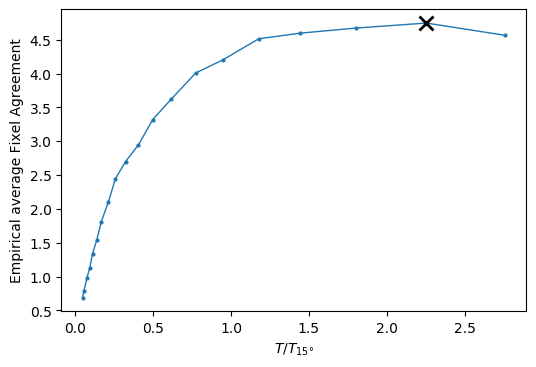

In [362]:
plot_mean("../models/Entrack/conditional/2019-11-13/22:24:08/agreement_sampled_jb_1")

In [159]:
get_max_from("../models/Entrack/conditional/2019-11-13/22:24:08/agreement_sampled_jb_1", key="mean")

(0.024441322168822742, 4.746760307716523)

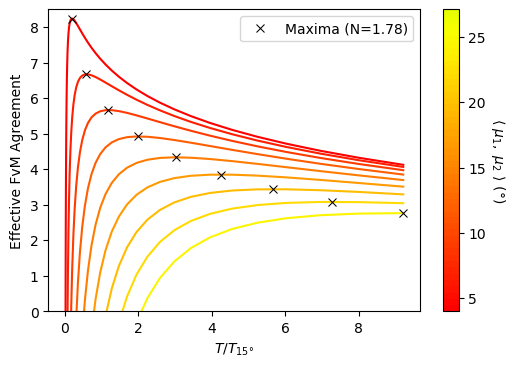

In [353]:
r2ycolors = cm.get_cmap('hsv', 256)(np.linspace(0, 1.5/8, 256))
r2ycmp = ListedColormap(r2ycolors)

plt.figure(dpi=100)

T=np.geomspace(0.0001, 0.1)
theta=np.linspace(4,30,10)[:9]
Tmax=[]
Vmax=[]
for i, th in enumerate(theta):
    t = T/ effective_T(np.pi/180*15)
    a = agreement(np.sqrt(2+2*np.cos(th/180*np.pi)), 1.78/T)
    plt.plot(t, a, color=r2ycmp(i/len(theta)))
    tmax, vmax = get_max(t, a)
    Tmax.append(tmax)
    Vmax.append(vmax)

plt.plot(Tmax,Vmax, "x", color="k", label=r"Maxima (N=1.78)", markeredgewidth=0.75)

cb = plt.colorbar(cm.ScalarMappable(norm=Normalize(vmin=theta.min(), vmax=theta.max(), clip=False),
                               cmap=r2ycmp))
cb.set_label(r"$\langle\ \mu_1,\ \mu_2\ \rangle$ (°)", rotation=270, labelpad=15)

plt.ylim(0, 8.5)
plt.legend()
#plt.xticks()
plt.xlabel(r"$T/T_{15°}$")
plt.ylabel(r"Effective FvM Agreement");

In [216]:
bits_from(0.87441831*effective_T(np.pi/180*15)) # 9999

6.098329668536923

In [213]:
bits_from(0.67337593*effective_T(np.pi/180*15)) # 999

6.458873092858709

In [210]:
bits_from(0.52640826492*effective_T(np.pi/180*15)) # 995

6.891310961660826

In [204]:
bits_from(0.445062498389*effective_T(np.pi/180*15)) #990

7.095408542240884

In [325]:
bits_from(0.001)

8.477996731255915

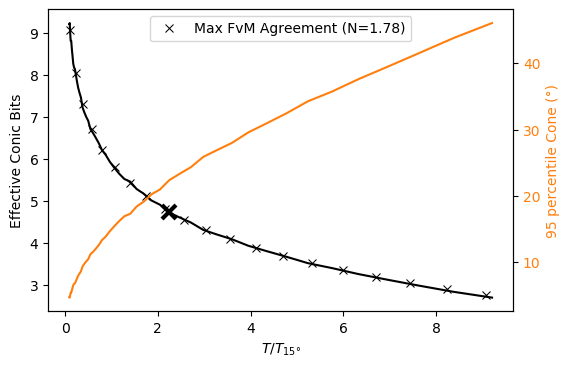

In [336]:
T=np.geomspace(0.001, 0.1)

fig, ax1 =plt.subplots(dpi=100)
ax1.plot(T/ effective_T(np.pi/180*15), bits_from(T), color="k")
ax1.set_ylabel("Effective Conic Bits", color="k")
ax1.tick_params(axis='y', labelcolor="k")
ax1.set_xlabel(r"$T/T_{15°}$")
#ax1.set_xscale("log")
ax1.tick_params(axis='y', labelcolor="k")


theta=np.linspace(3,27, 20)
Tmax=[]
Vmax=[]
n=1.78
for th in theta:
    t=np.geomspace(0.001, 0.1)
    tmax, vmax = get_max(
        t/ effective_T(np.pi/180*15),
        agreement(np.sqrt(2+2*np.cos(th/180*np.pi)), n/t)
    )
    Tmax.append(tmax)
    Vmax.append(vmax)
ax1.plot(Tmax, Vmax, "x", color="k", label="Max FvM Agreement (N=1.78)", markeredgewidth=0.75)
ax1.legend(loc='upper center')

it, imax = get_max_from("../models/Entrack/conditional/2019-11-13/22:24:08/agreement_sampled_jb_1", key="mean")

ax1.plot([it/ effective_T(np.pi/180*15)],[imax], "x", color="k", markersize=10, markeredgewidth=3)

ax2 = ax1.twinx()
ax2.plot(T/ effective_T(np.pi/180*15), effective_angle(T)/np.pi*180, color="tab:orange")
#ax2.plot([1,1,5],[4,15,15], "--", color="tab:orange", linewidth=1)
ax2.set_ylabel("95 percentile Cone (°)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange");

In [95]:
effective_angle(0.0052)/np.pi*180

11.948329343014592